In [13]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-11-21 10:26:46--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   233MB/s    in 0.3s    

2022-11-21 10:26:46 (233 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [21]:
#Importing modules
from keras.applications.inception_v3 import  InceptionV3
import keras
import os
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from zipfile import *
from keras.preprocessing.image import ImageDataGenerator

In [18]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

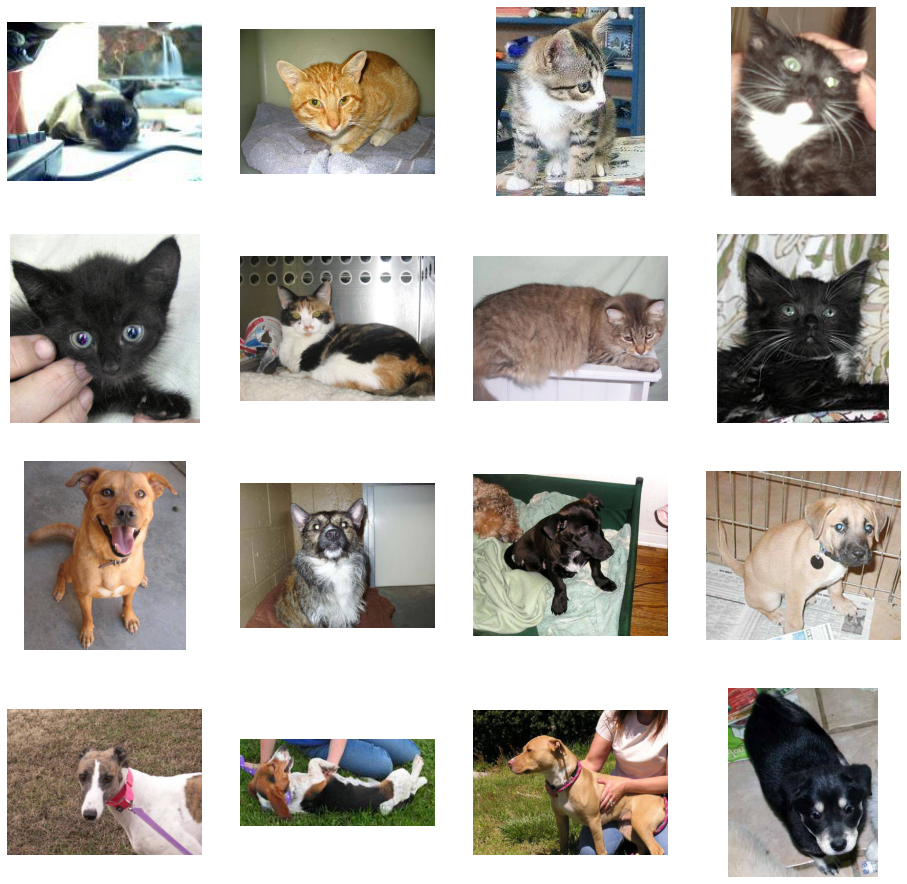

In [19]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

#### Image Augmentation

In [22]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

#### Training and Validation Sets

In [23]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Loading the Base Model

In [24]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [25]:
for layer in base_model.layers:
    layer.trainable = False

#### Compile and Fit

In [27]:
# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = keras.layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = keras.layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.7290 - acc: 0.6680

In [ ]:
!pip install -q streamlit

In [ ]:
model.save('./model.h5')

In [ ]:
!pip install -q streamlit-option-menu

In [ ]:
%%writefile app.py
import streamlit as st
import cv2
import tensorflow as tf 
import numpy as np
from keras.models import load_model
import sys
from streamlit_option_menu import option_menu

#Loading the Inception model
model= load_model('./model.h5',compile=(False))
st.markdown('',unsafe_allow_html=True)



#Functions
def predict(frame, model):
    # Pre-process the image for model prediction
    img = cv2.resize(frame, (299, 299))
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)

    img /= 255.0

    # Predict with the Inceptionv3 model
    prediction = model.predict(img)

    # Convert the prediction into text
    pred_text = tf.keras.applications.inception_v3.decode_predictions(prediction, top=1)
    for (i, (imagenetID, label, prob)) in enumerate(pred_text[0]):
        label  = ("{}: {:.2f}%".format(label, prob * 100))

    st.markdown(label)


def predict2(frame, model):
    # Pre-process the image for model prediction
    img = cv2.resize(frame, (299, 299))
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)

    img /= 255.0

    # Predict with the Inceptionv3 model
    prediction = model.predict(img)

    # Convert the prediction into text
    pred_text = tf.keras.applications.inception_v3.decode_predictions(prediction, top=1)
    for (i, (imagenetID, label, prob)) in enumerate(pred_text[0]):
        pred_class = label
       

    return pred_class

def object_detection(search_key,frame, model):
    label = predict2(frame,model)
    label = label.lower()
    try:
        if label.find(search_key) > -1:
            sys.exit( st.image(frame, caption=label))
        else:
            pass  
           

    except:
        print('')
            
            
        



# Main App
def main():
    
    st.title("***Video Object Detection***")
    st.text("Computer Vision")

    
    choice = option_menu("Main Menu",["Home","Upload","About"],icons = ["house","cloud_upload","list-task"],menu_icon ="cast",default_index = 0,orientation = "horizontal")
    
    if choice == "Upload":
        st.subheader("Upload Your Video")

        video_file_path = st.file_uploader("accepting mp4,avi", type=["mp4", "avi"])

        if video_file_path is not None:
            path = video_file_path.name
            with open(path,mode='wb') as f: 
                f.write(video_file_path.read())         
                st.success("File Uploaded")
            cap = cv2.VideoCapture(path)
            frame_width = int(cap.get(3))
            frame_height = int(cap.get(4))

            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            output = cv2.VideoWriter('output.mp4', fourcc, 20.0, (frame_width, frame_height))
            
            if st.button("Detect Objects"):
                
                # Start the video prediction loop
                while cap.isOpened():
                    ret, frame = cap.read()
    
                    if not ret:
                        break
    
                    
                    predict(frame, model)
    
                    # Display the resulting frame
                    
                cap.release()
                output.release()
                cv2.destroyAllWindows()
                
            key = st.text_input('Search key')
            key = key.lower()
            
            if key is not None:
            
                if st.button("Search for an object"):
                    
                    
                    # Start the video prediction loop
                    while cap.isOpened():
                        ret, frame = cap.read()
        
                        if not ret:
                            break
        
                        # Perform object detection
                        object_detection(key,frame, model)
                        
                    cap.release()
                    output.release()
                    cv2.destroyAllWindows()

    elif choice == "Home":
        st.subheader("Detect Objects In Video")
        st.image("./car.jpg")
        
       

if __name__ == '__main__':
    main()